# Génération de la Frontière Efficiente de Markowitz

Ce notebook illustre l'utilisation de la méthode de scalarisation pour approximer la frontière efficiente d'un portefeuille d'actions du secteur Energie.


In [1]:

import matplotlib.pyplot as plt
from scipy.constants import sigma
from scipy.optimize import minimize
import os

from src.level1.functions import *

# Charger les données
df = pd.read_csv('../datasets/Information_Technology.csv', index_col=0, parse_dates=True)

for file in os.listdir('../datasets/'):
    if file.endswith('.csv') and 'Information_Technology' not in file:
        temp_df = pd.read_csv(os.path.join('../datasets/', file), index_col=0, parse_dates=True)
        df = df.join(temp_df, how='inner')

In [2]:
df

,AAPL,MSFT,NVDA,AVGO,AMD,INTC,QCOM,TXN,MU,ORCL,...,WELL,EQIX,NEE,DUK,SO,D,AEP,EXC,SRE,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.237545,39.858456,0.483038,7.574802,2.670000,27.896452,54.612610,39.557953,33.919167,37.583099,...,50.148026,175.042114,20.032856,53.362503,30.940670,49.050900,41.371311,18.123079,40.092155,25.736317
2015-01-05,23.554739,39.491917,0.474880,7.453717,2.660000,27.581890,54.355274,38.944038,32.972355,37.056019,...,50.767147,173.242676,19.820679,52.594288,30.809048,48.455883,40.762409,17.606934,39.358929,25.444193
2015-01-06,23.556953,38.912292,0.460482,7.284194,2.630000,27.067846,53.583282,38.300499,32.084114,36.673496,...,51.490536,169.466141,19.897663,53.457718,31.178818,48.209023,40.985676,17.471867,38.990528,25.579569
2015-01-07,23.887280,39.406670,0.459282,7.480960,2.580000,27.635595,54.208225,38.988415,31.332521,36.681988,...,51.966248,170.022186,20.079794,53.629158,31.523499,48.405239,41.567505,17.495979,39.620026,25.800449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,257.853760,434.901794,139.899521,243.627975,125.059998,20.440001,155.851318,185.700836,89.446556,169.989212,...,124.210960,927.127563,70.180817,104.529366,80.157600,51.844440,88.959755,36.136345,85.451744,65.988266
2024-12-27,254.439240,427.377319,136.980164,240.043442,125.190002,20.299999,154.583130,185.168137,88.261497,167.296021,...,122.844925,921.526001,69.928688,104.558319,80.447891,52.056801,89.394608,36.117046,85.607788,65.949562


In [3]:
# Calcul des rendements logarithmiques
returns = f_returns(df)

# Calcul des paramètres pour l'optimisation
mu = f_mu(returns)  # Annualisation (252 jours boursiers)
Sigma = f_sigma(returns)  # Annualisation de la matrice de covariance
num_assets = len(mu)

# Calcul des Paramètres d'Optimisation

Les rendements logarithmiques sont calculés comme :

$  r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $

Le vecteur des rendements moyens annualisés :

$ \mu = \frac{1}{T} \sum_{t=1}^T r_t \times 252 $

La matrice de covariance annualisée :

$ \Sigma = \frac{1}{T} \sum_{t=1}^T (r_t - \bar{r})(r_t - \bar{r})^T \times 252 $


# Méthode de résolution par scalarisation pour générer la frontière efficiente

Fonction rendement : $ F_1(w) = - (w^T \mu) $

Fonction risque : $ F_2(w) = w^T \Sigma w $

Fonction objectif scalarisée : $ F(w) = \lambda \cdot (w^T \Sigma w) - (1 - \lambda) \cdot (w^T \mu) $

In [4]:
lambdas = np.linspace(0, 1, 50)  # 100 points entre 0 et 1
frontier_returns, frontier_volatilities, frontier_weights = optimize_portfolio(lambdas, mu, Sigma)

# Génération de la Frontière Efficiente

En faisant varier \(\lambda\) de 0 à 1, nous obtenons différents portefeuilles optimaux.


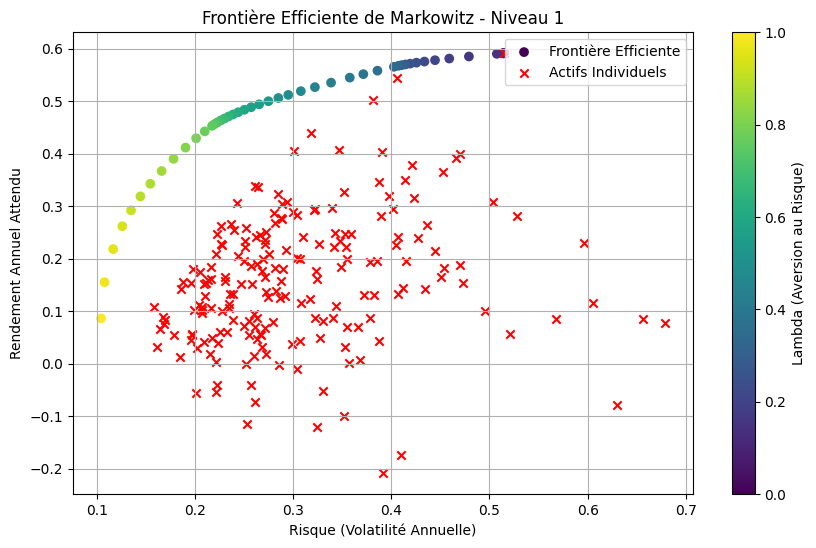

In [5]:
# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.scatter(frontier_volatilities, frontier_returns, c=lambdas, cmap='viridis', label='Frontière Efficiente')
plt.scatter(np.sqrt(np.diag(Sigma)), mu, c='red', marker='x', label='Actifs Individuels')
plt.colorbar(label='Lambda (Aversion au Risque)')
plt.xlabel('Risque (Volatilité Annuelle)')
plt.ylabel('Rendement Annuel Attendu')
plt.title('Frontière Efficiente de Markowitz - Niveau 1')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
print("Le portefeuille avec le rendement le plus élevé :")
max_return_index = np.argmax(frontier_returns)
print(f"Rendement : {frontier_returns[max_return_index]:.4f}, Volatilité : {frontier_volatilities[max_return_index]:.4f}")
weights = frontier_weights[max_return_index]
weights[weights < 1e-4] = 0  # Nettoyer les poids très faibles pour l'affichage
print(f"Actifs sélectionnés :")
for i, weight in enumerate(weights):
    if weight > 0:
        print(f"  {df.columns[i]} : {weight:.4f}")
#print(f"Poids : {weights}")

print("\nLe portefeuille avec le risque le plus faible :")
min_risk_index = np.argmin(frontier_volatilities)
print(f"Rendement : {frontier_returns[min_risk_index]:.4f}, Volatilité : {frontier_volatilities[min_risk_index]:.4f}")
weights = frontier_weights[min_risk_index]
weights[weights < 1e-4] = 0  # Nettoyer les poids très faibles pour l'affichage
print(f"Actifs sélectionnés :")
for i, weight in enumerate(weights):
    if weight > 0:
        print(f"  {df.columns[i]} : {weight:.4f}")
#print(f"Poids : {weights}")

Le portefeuille avec le rendement le plus élevé :
Rendement : 0.5910, Volatilité : 0.5145
Actifs sélectionnés :
  NVDA : 1.0000

Le portefeuille avec le risque le plus faible :
Rendement : 0.0863, Volatilité : 0.1043
Actifs sélectionnés :
  PANW : 0.0116
  TSM : 0.0446
  CRWD : 0.0041
  VZ : 0.0838
  EA : 0.0547
  TTWO : 0.0264
  MCD : 0.0742
  HLT : 0.0007
  ORLY : 0.0287
  WMT : 0.0767
  MO : 0.0138
  PM : 0.0072
  KMB : 0.0517
  CL : 0.0408
  GIS : 0.0058
  KR : 0.0234
  CPB : 0.0375
  CHD : 0.0166
  XOM : 0.0298
  TRV : 0.0052
  JNJ : 0.1117
  PFE : 0.0165
  MRK : 0.0682
  ABBV : 0.0149
  BMY : 0.0262
  HUM : 0.0170
  LMT : 0.0875
  LUV : 0.0005
  OTIS : 0.0006
  O : 0.0156
  DUK : 0.0042


# Autre approche

In [7]:
def portfoliorisk(w, cov_matrix):
    """Calcule la variance du portefeuille (le risque)"""
    return w.T @ cov_matrix @ w

In [8]:
# Contrainte : la somme des poids doit être égale à 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bornes : chaque poids est entre 0 et 1 (pas de vente à décourt)
bounds = tuple((0, 1) for _ in range(len(mu)))

# Contrainte de rendement minimum (elle sera ajoutée plus tard pour chaque valeur de r_min)
# Elle sera de la forme : {'type': 'ineq', 'fun': lambda w: w.T @ mu - r_min}

In [ ]:
# 1. Choisis une plage de rendements cibles (r_min)
#    Trouve le rendement minimum (portefeuille le plus sûr) et maximum (portefeuille le plus risqué) possibles.
#    Cela te donne les extrémités de ton front de Pareto.

# Exemple : crée 50 points de rendement cible entre ces deux extremes
target_returns = np.linspace(mu.min(), mu.max(), 50)

# 2. Lists pour stocker les résultats
optimal_risks = []
optimal_weights = []

# 3. Pour chaque rendement cible, résous le problème d'optimisation
for r_min in target_returns:
    # Ajouter la contrainte de rendement pour cette itération
    constraints_with_return = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: w.T @ mu - r_min}
    )

    # Faire une supposition initiale (répartition équitable)
    initial_guess = np.array([1/len(mu)] * len(mu))

    # Résoudre le problème de minimisation
    result = minimize(portfoliorisk, initial_guess,
                      args=(Sigma,), method='SLSQP',
                      bounds=bounds, constraints=constraints_with_return)

    # Si la résolution a réussi, stocke le risque optimal et les poids
    if result.success:
        optimal_risks.append(result.fun)
        optimal_weights.append(result.x)
    else:
        # Gérer les erreurs (cela peut arriver pour des rendements cibles trop extrêmes)
        optimal_risks.append(np.nan)
        optimal_weights.append(np.nan)

# Convertir les listes en arrays numpy
optimal_risks = np.array(optimal_risks)

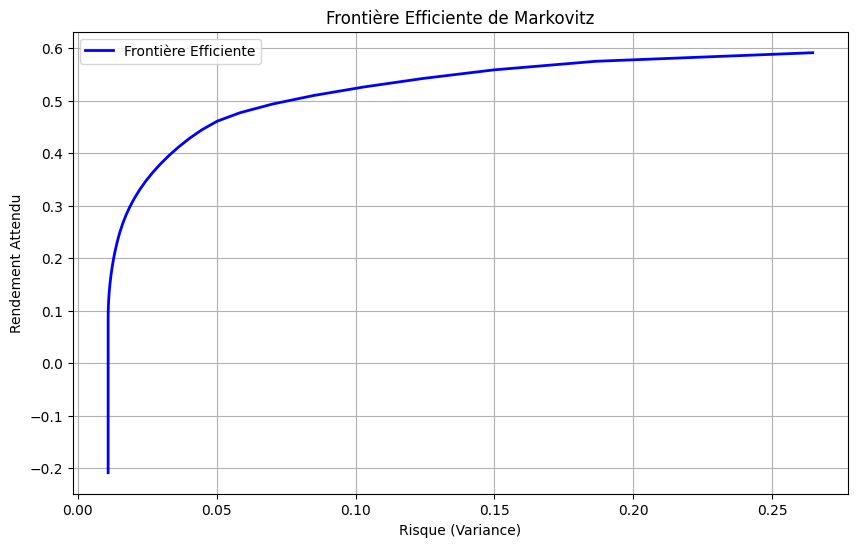

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(optimal_risks, target_returns, 'b-', linewidth=2.0, label='Frontière Efficiente')
plt.xlabel('Risque (Variance)')
plt.ylabel('Rendement Attendu')
plt.title('Frontière Efficiente de Markovitz')
plt.grid(True)
plt.legend()
plt.show()